# Mod√©lisation des s√©ries temporelles avec LSTM : Cas pratique et impl√©mentation

## 1. Introduction
Ce tutorial s'adresse aux debutants qui veulent monter en competence sur l'etude et la visualisation des donn√©es sequentielles. Nous allons utiliser des approches statistiques pour determiner quels mod√©le est mieu adapter au traitement du jeu de donnees. Dans ce tutoriels, nous apprenons les models ARIMA, SARIMA, SARIMAX et LSTM et comprendre leurs differences et leurs utilisations. 
nous analysons le dataset [Household Electric Power Consumption](https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set/data).

## 2. Exploration des Donn√©es (EDA)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [25]:
print("The current repertory :", os.getcwd())

The current repertory : /home/kd/Desktop/DL_TimeSeries/tests


In [26]:
file_path = '../data/individual+household+electric+power+consumption/household_power_consumption.txt'
if os.path.exists(file_path):
    print("File found!")
else: 
    print("File NOT found, Check the path please!")

File found!


In [27]:

def read_file(file_path):
    df = pd.read_csv(file_path, sep=';', na_values='?', low_memory=False)

    # Fusionner Date et Time en datetime apr√®s chargement
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

    # Supprimer les colonnes originales (car elles sont maintenant dans datetime)
    df.drop(columns=['Date', 'Time'], inplace=True)

    df.set_index('datetime', inplace=True)  # D√©finir 'datetime' comme index
    df.sort_index(inplace=True)
    print(df.index.min(), df.index.max())

    return df

df = read_file(file_path)
df.head()

2006-12-16 17:24:00 2010-11-26 21:02:00


Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [29]:
# V√©rification des Valeurs Manquantes

missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [30]:
# Statistiques Deescriptives
df.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

L‚Äôanalyse statistique descriptive nous donne un aper√ßu des valeurs centrales, des dispersions et des extr√™mes pour chaque variable du dataset Household Power Consumption.
- ***Global Active Power***
    - Moyenne (mean) : 1.09 kW ‚Üí La consommation √©lectrique moyenne est d'environ 1 kW.
    - Min & Max : 0.076 kW √† 11.12 kW ‚Üí La consommation varie fortement, avec des pics √©lev√©s.
    - √âcart-type (std) : 1.06 kW ‚Üí Forte dispersion, ce qui indique que la consommation fluctue beaucoup.
    - Distribution : La m√©diane (50%) est 0.6 kW, ce qui montre que la majorit√© des valeurs sont inf√©rieures √† la moyenne (distribution asym√©trique √† droite).
    - Valeurs extr√™mes (outliers) : Des pics jusqu'√† 11.12 kW indiquent des p√©riodes de consommation tr√®s √©lev√©e
- ***Global Reactive Power***
    - Moyenne : 0.12 kW ‚Üí Relativement faible, ce qui est normal car la puissance r√©active est l‚Äô√©nergie non consomm√©e (pertes).
    - √âcart-type : 0.11 kW ‚Üí Variation significative, bien que les valeurs restent faibles.
    - Max : 1.39 kW ‚Üí Certaines p√©riodes pr√©sentent des pertes √©lectriques importantes.
- ***Voltage***
    - Moyenne : 240.8 V, avec un √©cart-type de 3.2 V ‚Üí La tension est stable, centr√©e autour de la valeur standard de 240 V.
    - Min & Max : 223.2 V √† 254.1 V ‚Üí Quelques fluctuations, mais dans une plage acceptable.
- ***Global Intensity***
    - Moyenne : 4.62 A, avec une m√©diane de 2.6 A ‚Üí L‚Äôintensit√© consomm√©e est g√©n√©ralement faible.
    - Max : 48.4 A ‚Üí Certains appareils gourmands en √©nergie peuvent provoquer des pics.

array([[<Axes: title={'center': 'Global_active_power'}>,
        <Axes: title={'center': 'Global_reactive_power'}>,
        <Axes: title={'center': 'Voltage'}>],
       [<Axes: title={'center': 'Global_intensity'}>,
        <Axes: title={'center': 'Sub_metering_1'}>,
        <Axes: title={'center': 'Sub_metering_2'}>],
       [<Axes: title={'center': 'Sub_metering_3'}>, <Axes: >, <Axes: >]],
      dtype=object)

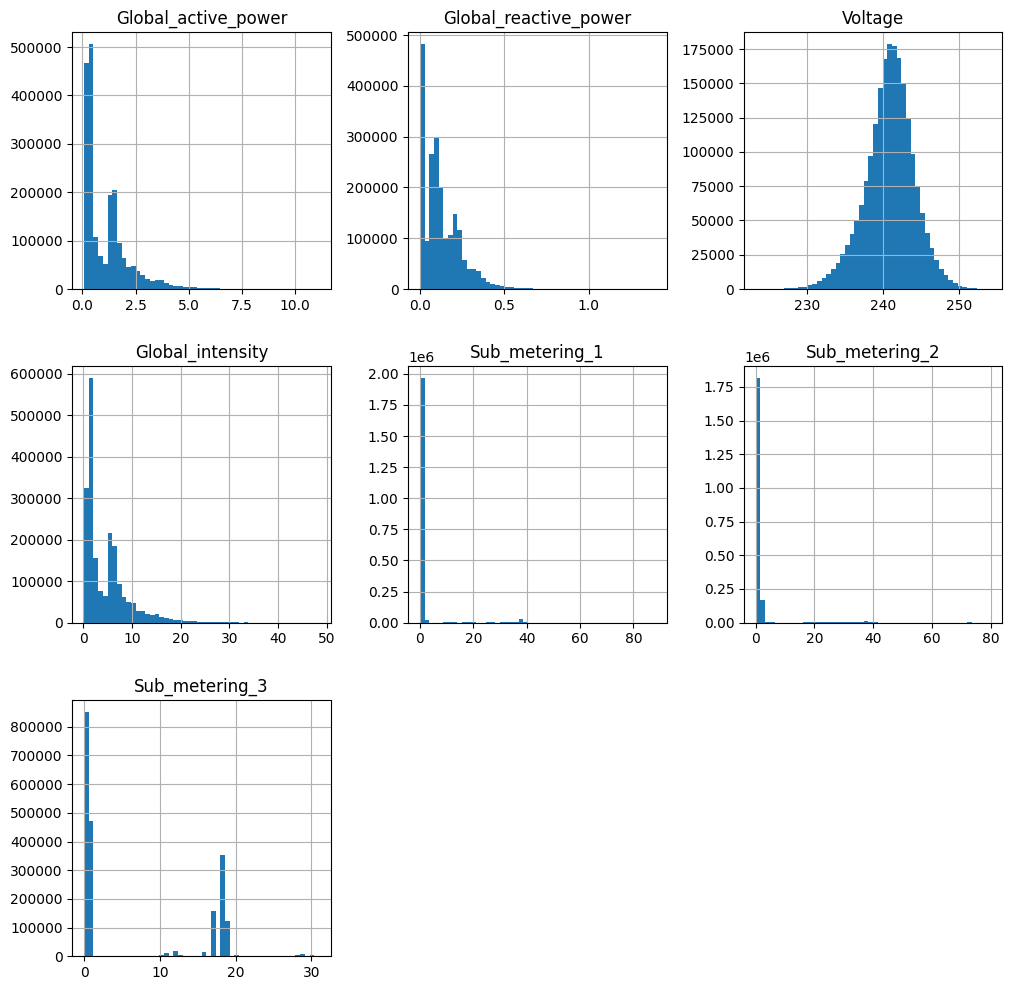

In [31]:
# Visualisation des Distributions

df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].hist(bins=50, figsize=(12, 12))

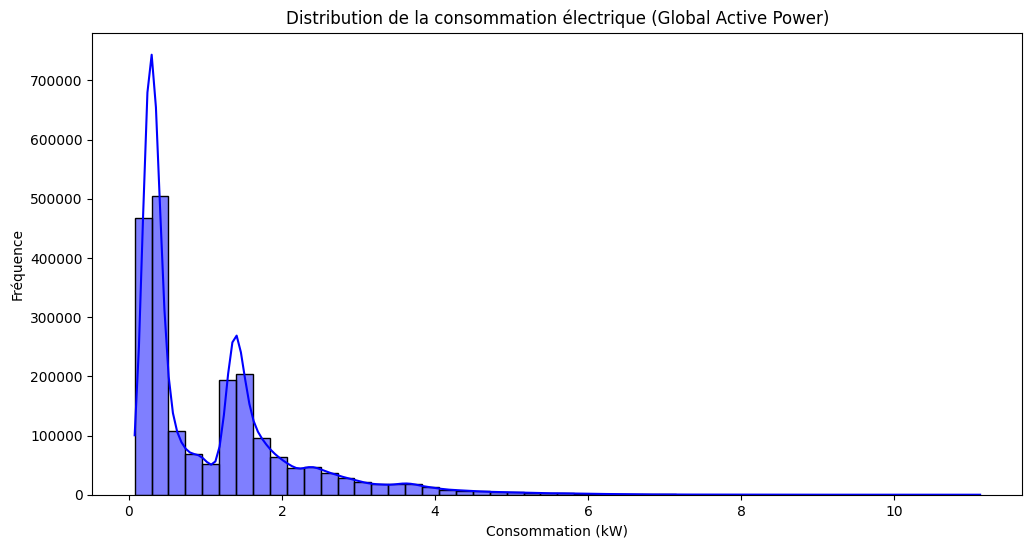

In [32]:
plt.figure(figsize=(12,6))
sns.histplot(df['Global_active_power'], kde=True, bins=50, color='blue')
plt.title("Distribution de la consommation √©lectrique (Global Active Power)")
plt.xlabel("Consommation (kW)")
plt.ylabel("Fr√©quence")
plt.show()

Le graph ci-dessus permet d'examiner la distribution des diff√©rentes variables du dataset Household Power Consumption.

- ***Global Active Power*** est fortement asym√©trique √† droite  ce qui indique que la plupart des valeurs sont inf√©rieur √† (< 2 kW), mais qu‚Äôil existe des valeurs plus √©lev√©es jusqu‚Äô√† environ 10 kW.
    - On observe deux pics distincts autour de 0.5 kW et 1.5 kW, ce qui peut sugg√©rer des cycles d'utilisation d'appareils √©lectriques.

- ***Voltage***  suit une courbe normale (distribution gaussienne) centr√©e autour de 240 V, ce qui est coh√©rent avec une alimentation √©lectrique standard.
    - Les fluctuations sont comprises entre 225 V et 255 V.
    - La pr√©sence d'une sym√©trie sugg√®re que la tension √©lectrique reste stable la plupart du temps.

- ***Global Intensity*** suit une distribution similaire √† la puissance active globale, car elle est directement li√©e √† la consommation √©lectrique (puissance = tension √ó intensit√©).
    - La majorit√© des valeurs sont faibles (< 10 A), mais il existe quelques valeurs plus √©lev√©es allant jusqu'√† 50 A.
- ***Sub_metering_1 et Sub_metering_2*** : On obseve que la majorit√© des valeurs sont proches de 0, indiquant que cette sous-mesure ne capture de l‚Äô√©nergie que dans certaines p√©riodes sp√©cifiques.
- ***Sub_metering_3*** On observe trois pics distincts ce qui peut √™tre li√© √† des variations de consommation en fonction des saisons.


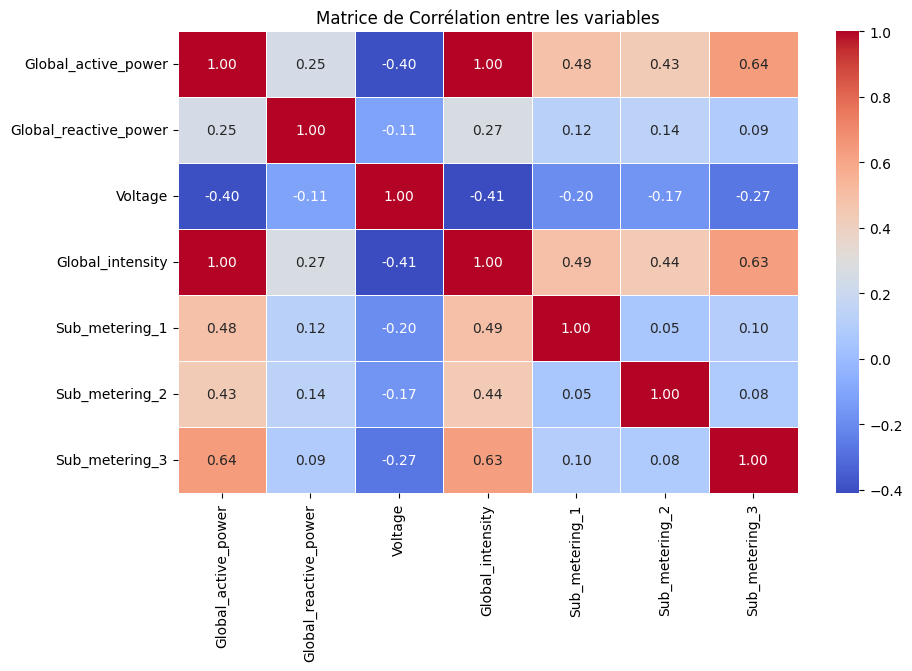

In [33]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corr√©lation entre les variables")
plt.show()


Ce heatmap de corr√©lation permet de visualiser les relations entre les variables du dataset. Cette matrice nous aide √† identifier les variables pertinentes pour pr√©dire la consommation.
- ***Variables fortement corr√©l√©es***
    - **Global_active_power et Global_intensity (+1.00)**: l'intensit√© √©lectrique est directement li√©e √† la puissance consomm√©e.
    - **Global_active_power et Sub_metering_3 (+0.64)**: la consommation mesur√©e par le compteur 3 contribue fortement √† la consommation totale.
    - **Global_intensity et Sub_metering_3 (+0.63)**: Une hausse de l'intensit√© est souvent associ√©e √† une augmentation de la consommation de ce compteur.
- ***Variables avec une corr√©lation n√©gative***
    - **Voltage et Global_active_power (-0.40)** : lorsque la puissance consomm√©e augmente, la tension a tendance √† baisser.
    - **Voltage et Global_intensity (-0.41)**: plus l‚Äôintensit√© augmente, plus la tension baisse, ce qui peut √™tre d√ª √† une chute de tension provoqu√©e par une forte demande.
- ***Variables faiblement corr√©l√©es***
    - **Global_reactive_power** a une faible corr√©lation avec la puissance active (0.25).
    - **L'heure (hour)** n'a qu'une l√©g√®re influence sur la consommation (0.28 avec Global_active_power).
    - **Les Sub_metering 1 & 2** sont peu corr√©l√©s aux autres variables, sugg√©rant qu‚Äôils mesurent des √©quipements sp√©cifiques.
    
La tension et l‚Äôintensit√© influencent directement la puissance consomm√©e.
Les sous-compteurs ont un impact in√©gal, sugg√©rant des usages diff√©rents.


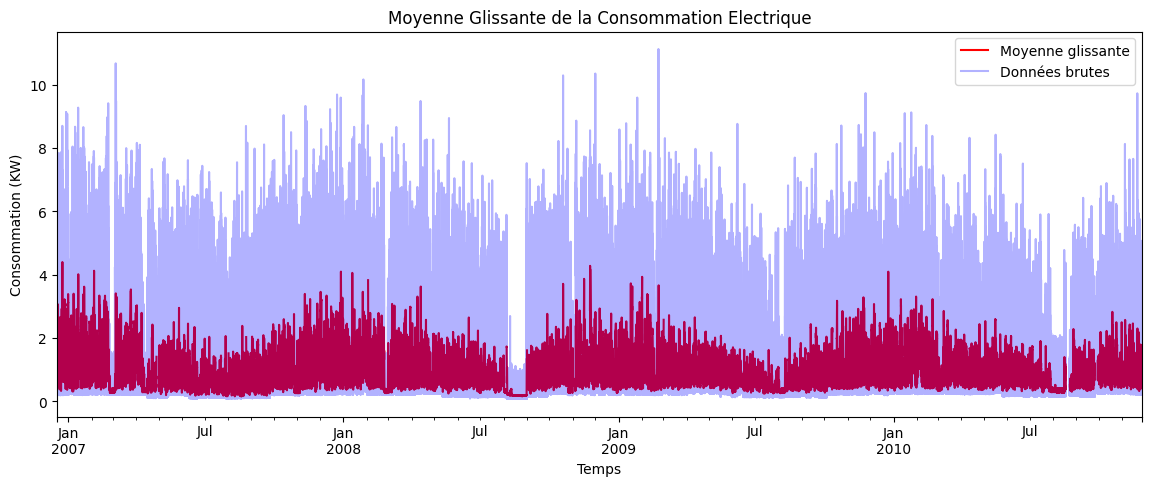

In [34]:
plt.figure(figsize=(14, 5))

# Utiliser directement df.index au lieu de df.set_index('datetime')
df['Global_active_power'].rolling(window=500).mean().plot(label='Moyenne glissante', color='red')
df['Global_active_power'].plot(alpha=0.3, label="Donn√©es brutes", color='blue')

plt.legend()
plt.title("Moyenne Glissante de la Consommation Electrique")
plt.xlabel("Temps")
plt.ylabel("Consommation (KW)")
plt.show()


Nous essayons d'analyser les tendances de consommation √©lectrique au fil du temps en utilisant une moyenne glissante.
- ***Donn√©es brutes (en bleu clair)***:
    - La s√©rie temporelle montre une forte variabilit√© avec des pics fr√©quents.
    - On observe des p√©riodes de consommation plus √©lev√©e que d'autres.
    - Des variations saisonni√®res peuvent √™tre identifi√©es, avec des cycles r√©currents.
- ***Moyenne glissante (en rouge fonc√©)***:
    - Elle permet de lisser les fluctuations en r√©v√©lant la tendance g√©n√©rale de la consommation.
    - On remarque une tendance √† la hausse et des variations cycliques
    - La consommation semble l√©g√®rement plus √©lev√©e en hiver.


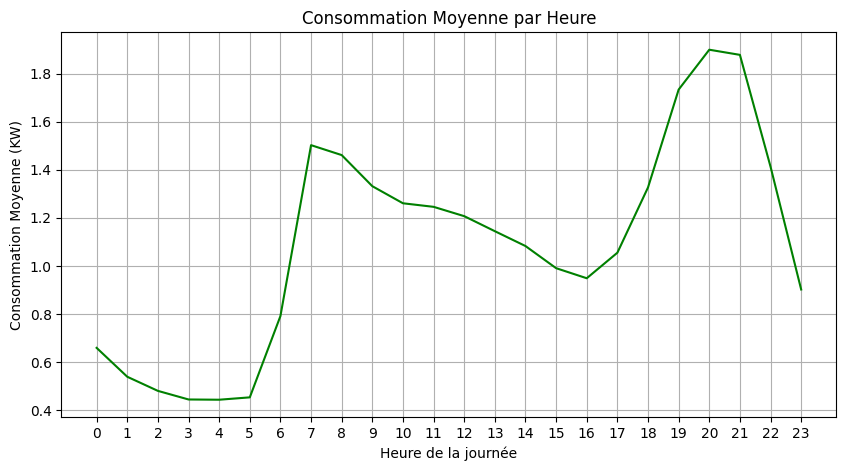

In [35]:
# Saisonni√®re - Moyenne par Heure

df['hour'] = df.index.hour  # Utilisation de l'index directement
hourly_avg = df.groupby('hour')['Global_active_power'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, markers='o', color='green')
plt.title("Consommation Moyenne par Heure")
plt.xlabel("Heure de la journ√©e")
plt.ylabel("Consommation Moyenne (KW)")
plt.xticks(range(0, 24))
plt.grid()
plt.show()


Ce graphique montre la moyenne de la consommation √©lectrique en fonction de l‚Äôheure de la journ√©e.
- ***Consommation basse pendant la nuit (0h - 5h)***:
    - La consommation commence faible aux alentours de 0.6 kW.
    - Elle atteint son point le plus bas entre 3h et 5h (environ 0.4 kW), ce qui est coh√©rent avec le fait que la plupart des appareils sont √©teints durant cette p√©riode.
- ***Forte augmentation entre 6h et 8h*** :
    - Vers 6h, on observe un pic brutal, atteignant environ 1.5 kW √† 7h - 8h. Cela correspond aux activit√©s du matin : √©clairage, pr√©paration du petit d√©jeuner, chauffage, √©lectrom√©nagers.
- ***Stabilisation en journ√©e (10h - 16h)*** :
La consommation baisse l√©g√®rement apr√®s 8h et atteint 0.9 kW au alentours de 16h pendant la journ√©e.
Cette stabilit√© peut √™tre due √† des appareils en veille ou au travail √† domicile.
- ***Nouveau pic en soir√©e (18h - 21h)*** :
    - √Ä 18h, la consommation commence √† remonter fortement. Elle culmine entre 20h et 21h avec une valeur proche de 1.9 kW.
    Ce pic est probablement li√© aux activit√©s du soir : retour √† la maison, pr√©paration du d√Æner, t√©l√©vision, chauffage, √©clairage.

- ***Forte baisse apr√®s 22h*** :
La consommation chute apr√®s 22h, indiquant une r√©duction des activit√©s domestiques avant la nuit.


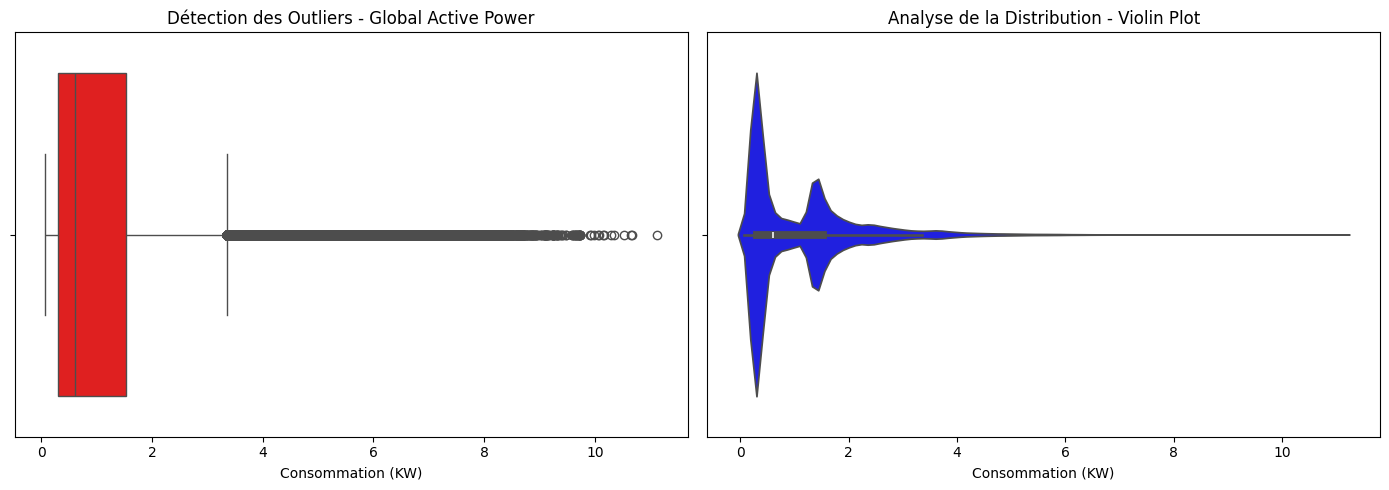

In [36]:
# Cr√©ation de la figure avec deux sous-graphiques c√¥te √† c√¥te
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot pour la d√©tection des outliers
sns.boxplot(x=df['Global_active_power'], color='red', ax=axes[0])
axes[0].set_title("D√©tection des Outliers - Global Active Power")
axes[0].set_xlabel("Consommation (KW)")

# Violin Plot pour l'analyse de la distribution
sns.violinplot(x=df['Global_active_power'], color='blue', ax=axes[1])
axes[1].set_title("Analyse de la Distribution - Violin Plot")
axes[1].set_xlabel("Consommation (KW)")

# Affichage du graphe
plt.tight_layout()
plt.show()


Le graphique ci-dessus affiche √† gauche un boxplot et √† droite un violin plot pour analyser la distribution et d√©tecter les valeurs aberrantes de la consommation √©lectrique (Global Active Power).
- ***Boxplot (Gauche)***
    - Le rectangle rouge repr√©sente l‚Äôintervalle interquartile (IQR), qui couvre 50% des valeurs.
    - La ligne centrale indique la m√©diane, et les "moustaches" √©tendent les donn√©es jusqu'√† 1.5 fois l'IQR.
    - Les points au-del√† des moustaches sont consid√©r√©s comme des outliers (valeurs extr√™mes).
    - Il semble y avoir de nombreuses valeurs extr√™mes au-dessus du maximum attendu.
- ***Violin Plot (Droite)***
    - Il montre une version liss√©e de l‚Äôhistogramme pour visualiser la densit√© des valeurs.
    On remarque une concentration des donn√©es autour des faibles valeurs de consommation entre 0 et 2 kW.
    Une forte densit√© autour de 1 kW, ce qui signifie que cette consommation est courante
  
Contrairement au boxplot, le violin plot montre comment les valeurs sont r√©parties.

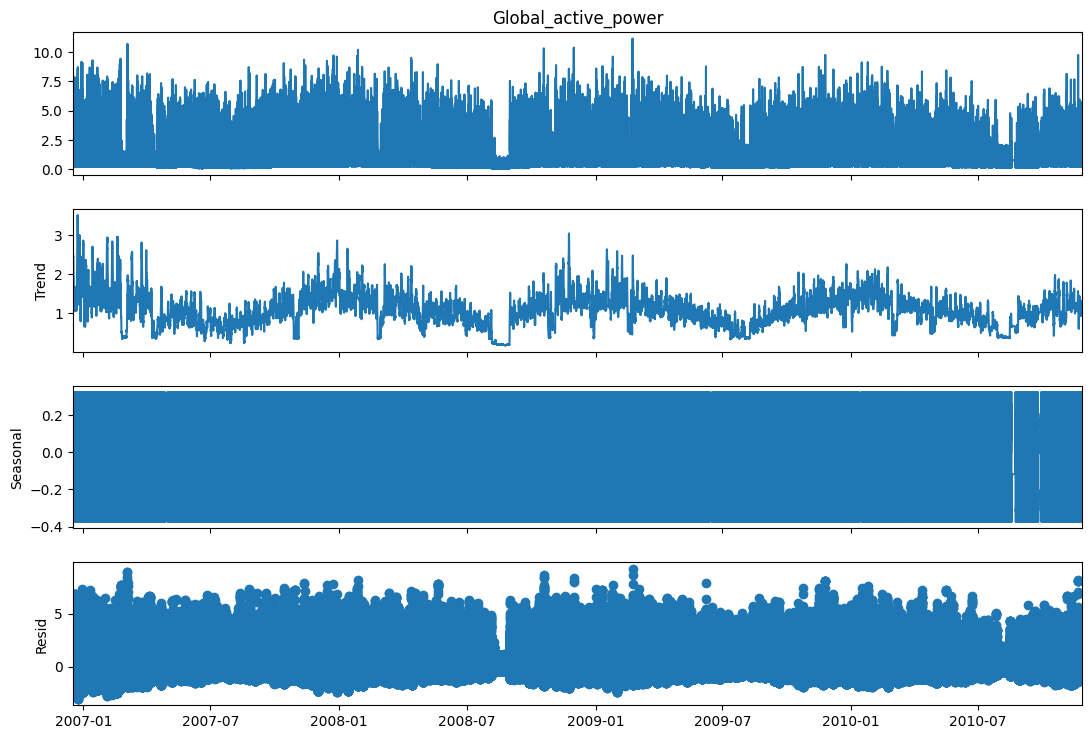

In [37]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

df = df.dropna(subset=['Global_active_power'])  # Supprime les valeurs NaN
decomposition = seasonal_decompose(df['Global_active_power'], period=1440)  # 1440 minutes = 1 jour

# Affichage propre du graphique
fig = decomposition.plot()
fig.set_size_inches(12, 8)  # Ajuste la taille du graphique
plt.show()


Le graphique affiche la d√©composition saisonni√®re de la s√©rie temporelle Global_active_power.

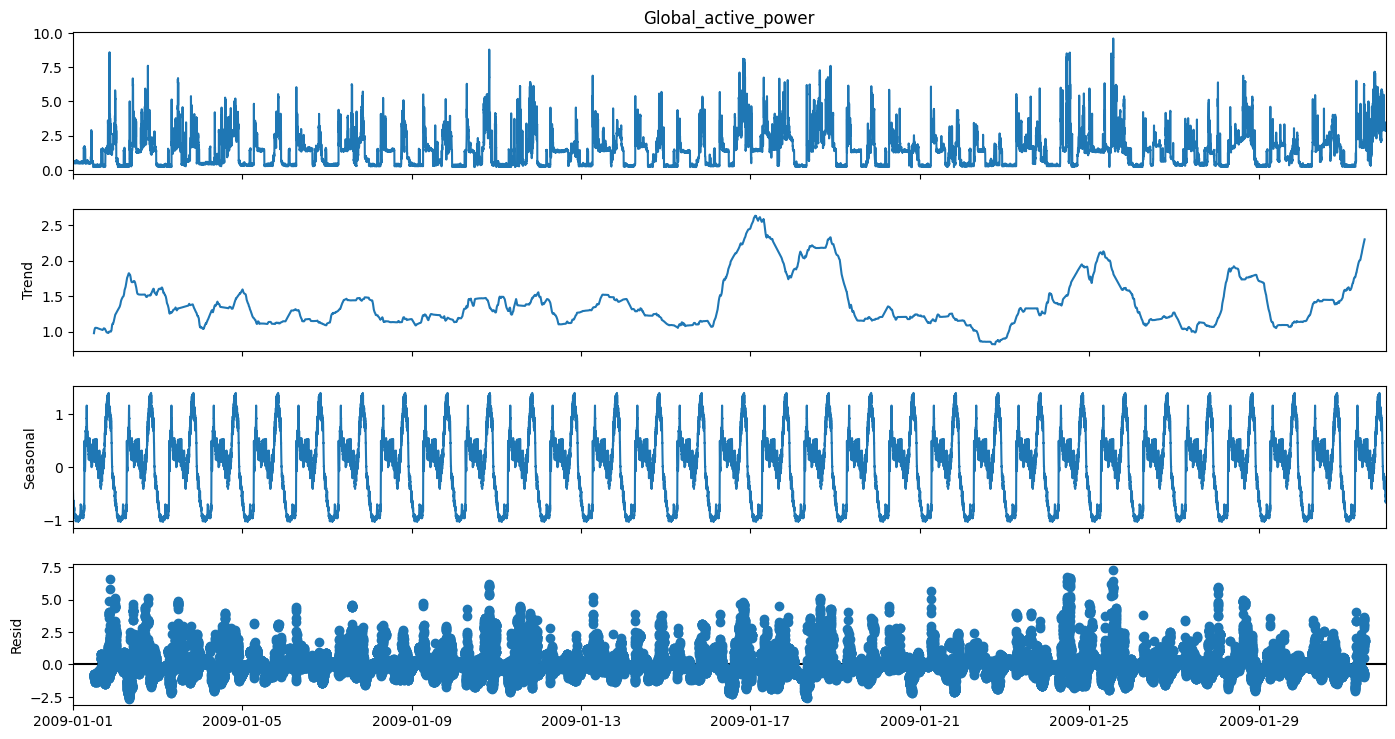

In [38]:
df_sample = df.loc['2009-01-01':'2009-01-31']
decomposition = seasonal_decompose(df_sample['Global_active_power'], period=1440)  # 1 jour
# Affichage propre du graphique
fig = decomposition.plot()
fig.set_size_inches(15, 8)  # Ajuste la taille du graphique
plt.show()


Ce graphique repr√©sente la d√©composition de la s√©rie temporelle pour la consommation √©lectrique (Global_active_power) sur un mois complet en janvier 2009.
- ***S√©rie Originale (Global_active_power)***
    - On observe d‚Äôimportantes variations de la consommation √©lectrique.
    - Les pics sont r√©guliers, souvent associ√©s aux moments de forte activit√© dans la journ√©e (ex. matin et soir).
    - On remarque aussi des p√©riodes de consommation tr√®s faible, probablement la nuit.
- ***Tendance (Trend)***
    - La tendance g√©n√©rale montre une √©volution progressive de la consommation.
    Il y a une hausse autour du 15 janvier et une diminution est visible autour du 19 janvier.
- ***Saisonnalit√© (Seasonal)***
    - La saisonnalit√© est bien marqu√©e avec un cycle de 24 heures.
    - Cela correspond aux habitudes quotidiennes des utilisateurs : forte consommation le matin et le soir.
    - Ce comportement r√©p√©titif confirme l'influence des rythmes de vie.
- ***R√©sidus (Resid)***
    - Ces r√©sidus repr√©sentent la partie impr√©visible de la s√©rie.
    - On observe des variations importantes, ce qui sugg√®re des anomalies ponctuelles.
    - Ces pics al√©atoires pourraient √™tre caus√©s par des √©v√©nements exceptionnels (ex. √©quipements activ√©s de mani√®re irr√©guli√®re).

- ***Test de Stationnarit√© Dickey-Fuller (adfuller)***
Le test de Dickey-Fuller Augment√© (ADF) v√©rifie si une s√©rie temporelle est stationnaire ou non stationnaire.

    - **Hypoth√®se nulle (H0)** : La s√©rie a une racine unitaire, donc elle n'est pas stationnaire (elle suit une tendance).
    - **Hypoth√®se alternative (H1)** : La s√©rie est stationnaire

- ***R√®gle de D√©cision***
    - Si p-value < 0.05 ‚Üí Rejet de H0 ‚Üí La s√©rie est stationnaire
    - Si p-value ‚â• 0.05 ‚Üí On ne rejette pas H0 ‚Üí La s√©rie n'est pas stationnaire

In [39]:
from statsmodels.tsa.stattools import adfuller
sample_size = 100_000  # Prendre un sous-√©chantillon de 100 000 points
df_sample = df['Global_active_power'].dropna().iloc[:sample_size]
result = adfuller(df_sample)
print(f"p-value: {result[1]}")

p-value: 3.52566982145228e-29


Une p-value tr√®s faible (3.52 √ó 10‚Åª¬≤‚Åπ, soit pratiquement 0) indique que l'hypoth√®se nulle (H0) est rejet√©e donc la s√©rie Global_active_power est stationnaire ! 

- Une s√©rie stationnaire a :

    - Une moyenne constante au fil du temps.
    - Une variance constante.
    - Une autocorr√©lation constante.

Si une s√©rie est stationnaire, elle est plus facile √† mod√©liser avec des m√©thodes comme ARIMA, LSTM, etc

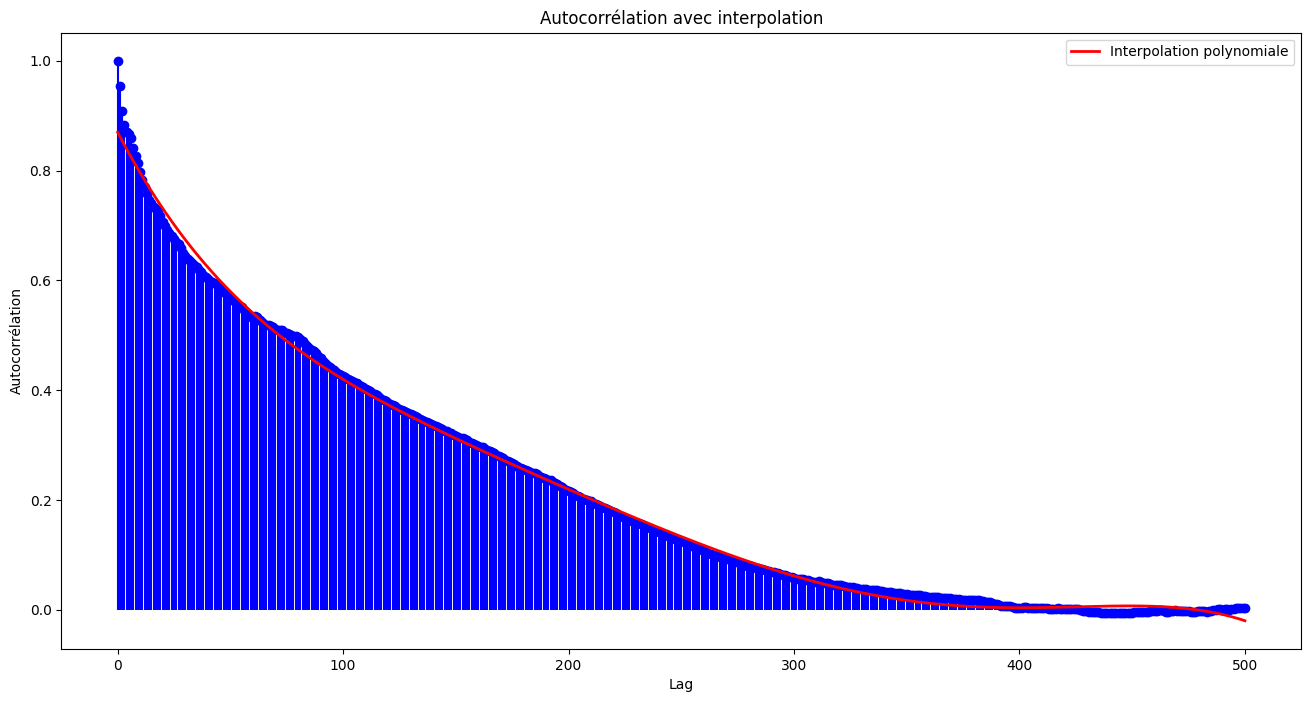

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Calculer l'ACF
from statsmodels.tsa.stattools import acf

lags = 500# Nombre de lags √† afficher
acf_values = acf(df_sample, nlags=lags)

# Interpolation avec une r√©gression polynomiale
x = np.arange(len(acf_values))
poly_coeffs = np.polyfit(x, acf_values, deg=5)  # Ajustement polynomial degr√© 5
poly_fit = np.polyval(poly_coeffs, x)

# Tracer l'ACF et l'interpolation
plt.figure(figsize=(16,8))
plt.stem(x, acf_values, linefmt='b-', markerfmt='bo', basefmt=" ")
plt.plot(x, poly_fit, 'r-', label="Interpolation polynomiale", linewidth=2)
plt.xlabel("Lag")
plt.ylabel("Autocorr√©lation")
plt.title("Autocorr√©lation avec interpolation")
plt.legend()
plt.show()


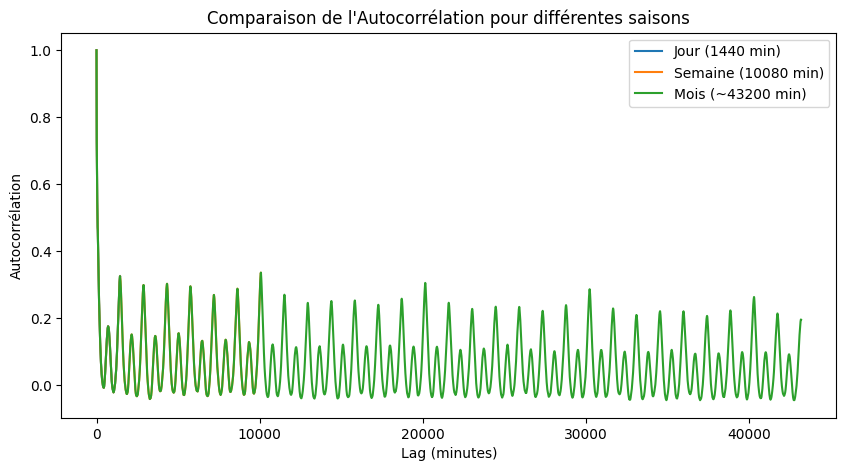

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# D√©finition des p√©riodes
lags_dict = {
    "Jour (1440 min)": 1440,
    "Semaine (10080 min)": 10080,
    "Mois (~43200 min)": 43200
}

plt.figure(figsize=(10, 5))

# Calcul et affichage de l'ACF pour chaque p√©riode
for label, nlags in lags_dict.items():
    acf_values = acf(df['Global_active_power'].dropna(), nlags=nlags)
    x = np.arange(len(acf_values))
    plt.plot(x, acf_values, label=label)

plt.xlabel("Lag (minutes)")
plt.ylabel("Autocorr√©lation")
plt.title("Comparaison de l'Autocorr√©lation pour diff√©rentes saisons")
plt.legend()
plt.show()


Le graphique montre l'autocorr√©lation de la consommation √©lectrique avec interpolation polynomiale.



## 2. ARIMA (AutoRegressive Integrated Moving Average) 

ARIMA est un mod√®le statistique utilis√© pour analyser et pr√©voir des s√©ries chronologiques. Il repose sur trois composants principaux : l'**auto-r√©gression (AR)**, l'**int√©gration (I)** et la **moyenne mobile (MA)**.  
Les mod√®les ARIMA visent √† d√©crire les **auto-corr√©lations** dans les donn√©es.

### üîπ Stationnarisation du processus avant mod√©lisation ARMA

Dans le cas o√π le processus **$(X_t)_{t \in \mathbb{Z}}$** n'est **pas stationnaire**, il est n√©cessaire de le **stationnariser** avant de pouvoir l'analyser √† l'aide d'un mod√®le **ARMA(p, q)**.

La stationnarisation permet de garantir que les propri√©t√©s statistiques du processus, telles que **la moyenne et la variance**, restent constantes dans le temps. Cette √©tape est essentielle pour assurer la validit√© des pr√©dictions et l'ajustement correct du mod√®le.


### üîπ D√©finition du mod√®le ARMA(p,q)

Un mod√®le **AutoR√©gressif et Moyenne-Mobile** d'ordres $(p,q)$ (**ARMA(p,q)**) est un **processus temporel discret** $(X_t, t \in \mathbb{N})$ v√©rifiant :

$$
X_t = \varepsilon_t + \sum_{i=1}^{p} \varphi_i X_{t-i} + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
$$

o√π :
- $\varphi_i$ sont les **param√®tres auto-r√©gressifs** du mod√®le (**AR(p)**).
- $\theta_i$ sont les **param√®tres de la moyenne mobile** (**MA(q)**).
- $\varepsilon_t$ est un **bruit blanc** (terme d'erreur al√©atoire).


### üîπ Cas particuliers :
- Un **mod√®le autor√©gressif** **AR(p)** est un **ARMA(p,0)** :
  
  $$
  X_t = \sum_{i=1}^{p} \varphi_i X_{t-i} + \varepsilon_t
  $$

- Un **mod√®le moyenne mobile** **MA(q)** est un **ARMA(0,q)** :

  $$
  X_t = \varepsilon_t + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
  $$

### üîπRemarque: 
Le processus ARMA n'est bien d√©fini que s'il est stationnaire.

### üîπ Mod√®le Auto-R√©gressif (AR)

AR est utilis√© pour d√©crire la relation entre la valeur actuelle et les valeurs pass√©es. Un mod√®le [**AR(p)**](https://fr.wikipedia.org/wiki/Processus_autor%C3%A9gressif) est d√©fini par :

$$
X_t = \sum_{i=1}^{p} \varphi_i X_{t-i} + \varepsilon_t
$$
$$
X_t = \varphi_1 X_{t-1} + \varphi_2 X_{t-2} + ... + \varphi_p X_{t-p} + \epsilon_t
$$

o√π : 

$
\varphi_i \quad \text{sont les coefficients du mod√®le auto-r√©gressif.} 
$

$
X_t \quad \text{est la valeur actuelle de la s√©rie temporelle.}
$

$
\epsilon_t \quad \text{est un bruit blanc.}
$

### üîπ Composante Moyenne Mobile (MA)

Si $\epsilon_t$ n'est pas une s√©quence de bruit blanc, elle est g√©n√©ralement consid√©r√©e comme une moyenne mobile **(MA)** d'ordre $q$.



Un mod√®le [**MA(q)**](https://fr.wikipedia.org/wiki/ARMA) est d√©fini comme suit :

$$
X_t = \mu + \varepsilon_t + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
$$

$$
X_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}
$$

$\textbf{o√π :}$
- $\theta_1, \dots, \theta_q$ sont les **param√®tres du mod√®le**.
- $\mu$ est **l'esp√©rance (moyenne) de $X_t$**.
- $\varepsilon_t, \varepsilon_{t-1}, \dots$ sont des **termes d'erreur (bruit blanc)**.


### üîπ Composante Int√©gr√©e (I)

L'int√©gration consiste √† diff√©rencier la s√©rie $d$ fois pour la rendre stationnaire :

$$
X_t' = X_t - X_{t-1}
$$

Si la s√©rie reste non stationnaire apr√®s une premi√®re diff√©renciation, on peut continuer jusqu'√† obtenir une s√©rie stationnaire apr√®s $d$ diff√©renciations :

$$
X_t^{(d)} = (1 - L)^d X_t
$$

o√π :
- $d$ : **Ordre de diff√©renciation**, indiquant combien de fois la s√©rie doit √™tre diff√©renci√©e pour devenir stationnaire.
- $L$ : **Op√©rateur de retard (lag operator)** 


### üîπ Mod√®le ARIMA(p,d,q) complet

Un mod√®le **ARIMA(p, d, q)** est une combinaison des mod√®les **AR(p)** et **MA(q)** appliqu√©s √† une s√©rie diff√©renci√©e **$d$** fois :

$$
\left( 1 - \sum_{i=1}^{p} \phi_i L^i \right) (1 - L)^d X_t =
\left( 1 + \sum_{j=1}^{q} \theta_j L^j \right) \epsilon_t
$$

o√π :
- $p$ : **Ordre du mod√®le Auto-R√©gressif (AR)**, c'est-√†-dire le nombre de termes pr√©c√©dents de $X_t$ utilis√©s pour pr√©dire la valeur actuelle.
- $d$ : **Ordre de diff√©renciation**, indiquant combien de fois la s√©rie doit √™tre diff√©renci√©e pour devenir stationnaire.
- $q$ : **Ordre du mod√®le de Moyenne Mobile (MA)**, repr√©sentant le nombre de termes d'erreur pr√©c√©dents utilis√©s dans la mod√©lisation.
- $\phi_i$ : **Coefficients du mod√®le AR**.
- $\theta_j$ : **Coefficients du mod√®le MA**.
- $\epsilon_t$ : **Bruit blanc**, une variable al√©atoire non corr√©l√©e de moyenne nulle.
- $L$ : **Op√©rateur de retard (lag operator)**, d√©fini comme :

$$
L X_t = X_{t-1}, \quad L^2 X_t = X_{t-2}, \quad \dots
$$


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# D√©finir et entra√Æner le mod√®le ARIMA
model = ARIMA(df['Global_active_power'], order=(1, 0, 1))
model_fit = model.fit()

# R√©sum√© du mod√®le
print(model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                34589
Model:                  ARIMA(1, 0, 1)   Log Likelihood              -32725.458
Date:                 Mon, 17 Mar 2025   AIC                          65458.917
Time:                         12:36:59   BIC                          65492.722
Sample:                     12-16-2006   HQIC                         65469.691
                          - 11-26-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0927      0.015     73.527      0.000       1.064       1.122
ar.L1          0.6605      0.005    136.606      0.000       0.651       0.670
ma.L1          0.1147      0.006     19.208 


- ***Structure du Mod√®le***

    Le mod√®le utilis√© est un **ARIMA(1,0,1)**, ce qui signifie :

    - **$p = 1$** : Une seule observation pass√©e est utilis√©e pour la pr√©diction (**processus auto-r√©gressif**).
    - **$d = 0$** : Aucune diff√©renciation n‚Äôa √©t√© appliqu√©e aux donn√©es (**elles sont suppos√©es stationnaires**).
    - **$q = 1$** : Une seule erreur pass√©e est prise en compte (**moyenne mobile**).

- ***Interpr√©tation des Coefficients***

    | **Param√®tre** | **Valeur** | **Interpr√©tation** |
    |--------------|-----------|----------------------------------------------|
    | **Constante** | 1.0927 | Indique une **valeur moyenne estim√©e** de la consommation √©lectrique. |
    | **AR(1)** | 0.6605 | Influence **mod√©r√©e** de la valeur pr√©c√©dente sur la pr√©diction. |
    | **MA(1)** | 0.1147 | Contribution **faible** des erreurs pass√©es √† la pr√©vision. |
    | **$\sigma^2$ (Variance des r√©sidus)** | 0.3884 | Mesure l'**incertitude du mod√®le**. |

    - **Le coefficient $AR(1) = 0.6605$** montre **une d√©pendance temporelle mod√©r√©e** des observations pass√©es sur les futures valeurs.  
    - **La faible valeur de $MA(1) = 0.1147$** indique que les **erreurs pass√©es influencent peu la pr√©diction**.  
    - **La variance des r√©sidus $\sigma^2 = 0.3884$** indique **un niveau d'incertitude raisonnable**, mais qui pourrait √™tre **r√©duit avec un mod√®le plus ajust√©**.



- ***Crit√®res de Performance du Mod√®le***

    | **Crit√®re** | **Valeur** | **Interpr√©tation** |
    |------------|-----------|------------------------------------------------|
    | **AIC** | 65 458.917 | Mesure la **qualit√© du mod√®le** (**plus bas = meilleur**). |
    | **BIC** | 65 492.722 | Indicateur similaire √† l'AIC, **p√©nalise la complexit√© du mod√®le**. |
    | **HQIC** | 65 469.691 | Variante de l‚ÄôAIC prenant en compte **la taille de l‚Äô√©chantillon**. |

    **Un AIC √©lev√© sugg√®re que le mod√®le peut √™tre am√©lior√©**, notamment en int√©grant **une composante saisonni√®re ou en ajustant les hyperparam√®tres**.


- ***Statistiques de R√©sidus***

    | **Test** | **Valeur** | **Interpr√©tation** |
    |------------|-----------|------------------------------------------------|
    | **Ljung-Box (Q) Test** | 0.07 | Test de corr√©lation des r√©sidus (**faible = erreurs al√©atoires**). |
    | **Prob(Q)** | 0.78 | Indique que **les r√©sidus sont relativement ind√©pendants**. |
    | **Jarque-Bera (JB)** | 23 916.93 | V√©rifie la **normalit√© des r√©sidus** (**valeur √©lev√©e = non normalit√©**). |
    | **Prob(JB)** | 0.00 | Confirme que **les r√©sidus ne suivent pas une distribution normale**. |
    | **H√©t√©rosc√©dasticit√© (H)** | 0.69 | **La variance des erreurs diminue l√©g√®rement au fil du temps**. |
    | **Skewness** | 1.16 | Indique **une asym√©trie des r√©sidus**. |
    | **Kurtosis** | 6.35 | Valeur √©lev√©e, indiquant **la pr√©sence de valeurs extr√™mes**. |

    - **Les r√©sidus ne suivent pas une distribution normale**, ce qui peut **affecter la pr√©cision des pr√©visions**.  
    - **L'h√©t√©rosc√©dasticit√© faible ($H = 0.69$) indique que la variance des erreurs n'est pas parfaitement constante**, un mod√®le plus flexible pourrait mieux capturer cette variabilit√©.

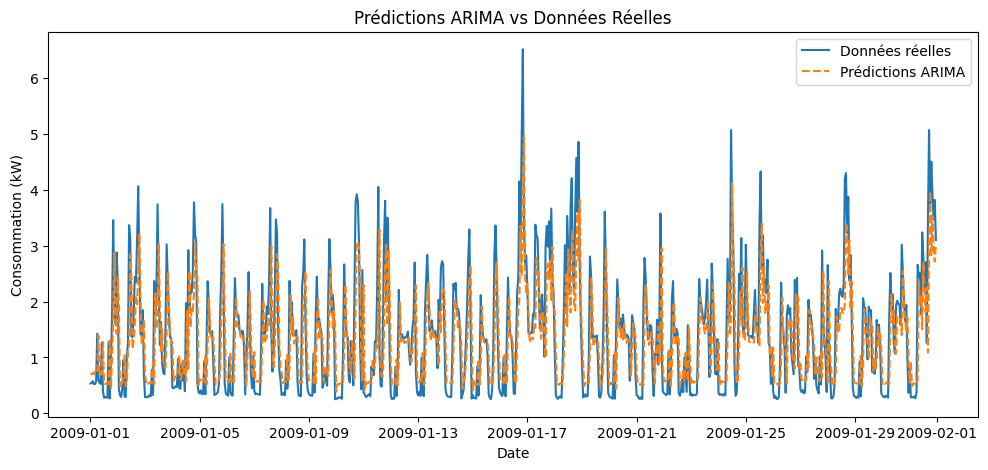

In [55]:
# Pr√©dictions avec index correct

df.loc[:, 'forecast'] = model_fit.predict(start=df.index[0], end=df.index[-1])
df_janvier_2009 = df.loc["2009-01-01":"2009-01-31"].copy()


# Visualisation
plt.figure(figsize=(12,5))
plt.plot(df_janvier_2009['Global_active_power'], label="Donn√©es r√©elles")
plt.plot(df_janvier_2009['forecast'], label="Pr√©dictions ARIMA", linestyle="dashed")
plt.title("Pr√©dictions ARIMA vs Donn√©es R√©elles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()

# Analyse du Graphique : Pr√©dictions ARIMA vs Donn√©es R√©elles (Janvier 2009)

L‚Äôimage repr√©sente les **pr√©dictions du mod√®le ARIMA** compar√©es aux **donn√©es r√©elles de consommation d‚Äô√©nergie** sur le mois de **janvier 2009**.


- ***Pr√©cision du Mod√®le***
    - **Les pr√©dictions suivent globalement la tendance des donn√©es r√©elles**, indiquant que le mod√®le **captive bien les fluctuations de consommation**.  
    - **Le mod√®le r√©ussit √† suivre les pics et les creux**, bien que **certains √©carts persistent**.


- ***Variabilit√© Temporelle***
    - **Le mod√®le capture les cycles journaliers de consommation**, montrant **une corr√©lation avec les variations horaires d‚Äôutilisation d‚Äô√©lectricit√©**.  
    - **Cependant, certains pics sont sous-estim√©s ou surestim√©s**, ce qui **pourrait √™tre am√©lior√© en int√©grant une meilleure prise en compte de la saisonnalit√©**.  


# √âvaluation du Mod√®le SARIMA

Une fois le mod√®le entra√Æn√©, nous pouvons utiliser plusieurs **m√©triques** pour juger de sa pertinence :


- ***Erreur Absolue Moyenne (MAE)***

    L'**Erreur Absolue Moyenne** (**MAE**) mesure l'√©cart moyen absolu entre les **pr√©dictions** et les **valeurs r√©elles** :

    $$
    MAE = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
    $$

    
    - **MAE faible** ‚Üí Le mod√®le **pr√©dit des valeurs proches des donn√©es r√©elles**.  
    - **MAE √©lev√©** ‚Üí Il y a **des √©carts importants en moyenne** entre les pr√©dictions et la r√©alit√©.


- ***Erreur Quadratique Moyenne (RMSE)***

    L'**Erreur Quadratique Moyenne** (**RMSE**) est une **mesure plus sensible aux grandes erreurs** :

    $$
    RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}
    $$

    - **Le RMSE p√©nalise davantage les grandes erreurs**, ce qui permet de d√©tecter si **le mod√®le est impr√©cis sur certaines valeurs extr√™mes**.  
    - **Un RMSE proche du MAE** indique que **les erreurs sont bien r√©parties** et qu'il n'y a **pas de grandes erreurs isol√©es**.  

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df['Global_active_power'], df['forecast'])
print(f"MAE: {mae}")

rmse = np.sqrt(mean_squared_error(df['Global_active_power'], df['forecast']))
print(f"RMSE: {rmse}")

MAE: 0.44539429799237845
RMSE: 0.6233558803254842


# **√âvaluation des Performances du Mod√®le ARIMA**

Apr√®s l'entra√Ænement du mod√®le, nous avons calcul√© les **m√©triques d'erreur** suivantes :

- ***Erreur Absolue Moyenne (MAE)***

    - **Le MAE indique que, en moyenne, les pr√©visions du mod√®le ARIMA s'√©cartent de 0.4454 kW des valeurs r√©elles.**  
    - **Un MAE faible** signifie que **le mod√®le est globalement pr√©cis**.


- ***Erreur Quadratique Moyenne (RMSE)***

    L'**Erreur Quadratique Moyenne** (**RMSE**) est d√©finie comme suit :

    - **Le RMSE est plus sensible aux grandes erreurs** : la valeur de **0.6234 kW** sugg√®re que **certaines pr√©visions pr√©sentent des √©carts plus importants**.  
    - **Un RMSE sup√©rieur au MAE** indique **que le mod√®le peine davantage √† pr√©dire les pics de consommation**.

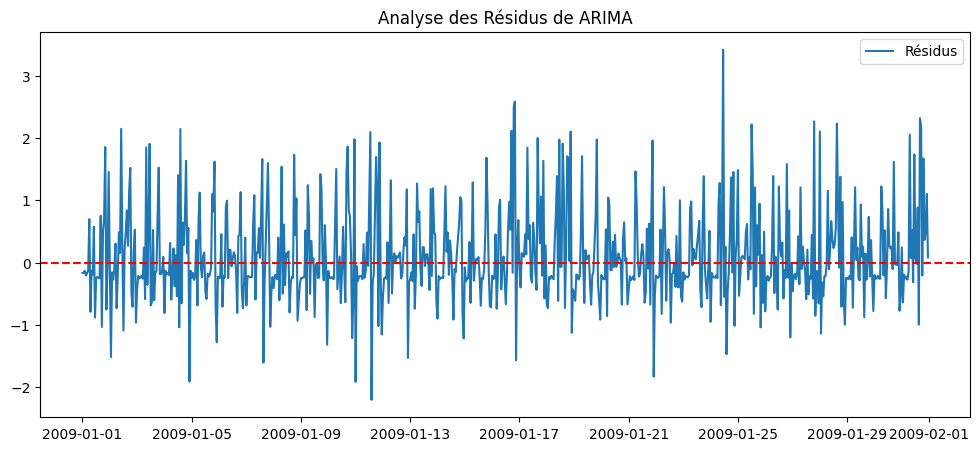

In [57]:
residuals = df_janvier_2009['Global_active_power'] - df_janvier_2009['forecast']
plt.figure(figsize=(12, 5))
plt.plot(df_janvier_2009.index, residuals, label="R√©sidus")
plt.axhline(0, linestyle='dashed', color='red')
plt.legend()
plt.title("Analyse des R√©sidus de ARIMA")
plt.show()


# **Analyse des R√©sidus du Mod√®le ARIMA**

L‚Äôimage montre **l‚Äôanalyse des r√©sidus du mod√®le ARIMA** appliqu√© √† la **consommation d‚Äô√©nergie** en **janvier 2009**.

- ***Centrage autour de z√©ro***
    - **Les r√©sidus fluctuent autour de la ligne rouge (moyenne nulle)**, ce qui est un bon indicateur que **le mod√®le ne pr√©sente pas de biais syst√©matique**.  

- ***Pr√©sence de motifs dans les erreurs***  
    - **Une dispersion irr√©guli√®re est visible**, notamment avec **des pics importants**, indiquant que **le mod√®le ne capture pas parfaitement toutes les dynamiques de la s√©rie**.  
    - **Certains pics soudains de r√©sidus** montrent **des erreurs plus marqu√©es √† certains moments**, sugg√©rant que **des √©v√©nements non mod√©lis√©s influencent les pr√©dictions**.

- ***H√©t√©rosc√©dasticit√© potentielle***
    - **L‚Äôintensit√© des r√©sidus semble varier par p√©riodes**, ce qui pourrait **indiquer une variance non constante**.  
    - **Ce ph√©nom√®ne pourrait √™tre mieux g√©r√© en int√©grant un mod√®le GARCH** ou en **appliquant une transformation logarithmique aux donn√©es**.


   Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3            datetime  
0             0.0             1.0            17.0 2006-12-16 17:24:00  
1             0.0             1.0            16.0 2006-12-16 17:25:00  
2             0.0             2.0            17.0 2006-12-16 17:26:00  
3             0.0             1.0            17.0 2006-12-16 17:27:00  
4             0.0             1.0            17.0 2006-12-16 17:28:00  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns)

/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.73979D-01    |proj g|=  3.92898D-01

At iterate    5    f=  4.99281D-01    |proj g|=  5.74329D-02

At iterate   10    f=  4.94258D-01    |proj g|=  4.60944D-02

At iterate   15    f=  4.91396D-01    |proj g|=  7.99359D-03

At iterate   20    f=  4.90774D-01    |proj g|=  9.00425D-03

At iterate   25    f=  4.90726D-01    |proj g|=  1.67562D-03

At iterate   30    f=  4.90704D-01    |proj g|=  4.89221D-03

At iterate   35    f=  4.90638D-01    |proj g|=  9.59091D-04

At iterate   40    f=  4.90636D-01    |proj g|=  4.05905D-04

At iterate   45    f=  4.90636D-01    |proj g|=  2.89176D-05

At iterate   50    f=  4.90636D-01    |proj g|=  3.18753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                  Global_active_power   No. Observations:                50000
Model:             SARIMAX(5, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -24531.790
Date:                              Sat, 22 Feb 2025   AIC                          49083.579
Time:                                      23:27:12   BIC                          49171.777
Sample:                                  12-16-2006   HQIC                         49111.207
                                       - 01-20-2007                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7191      0.007    107.298      0.000       0.706       0.732
ar.L2         -0.57

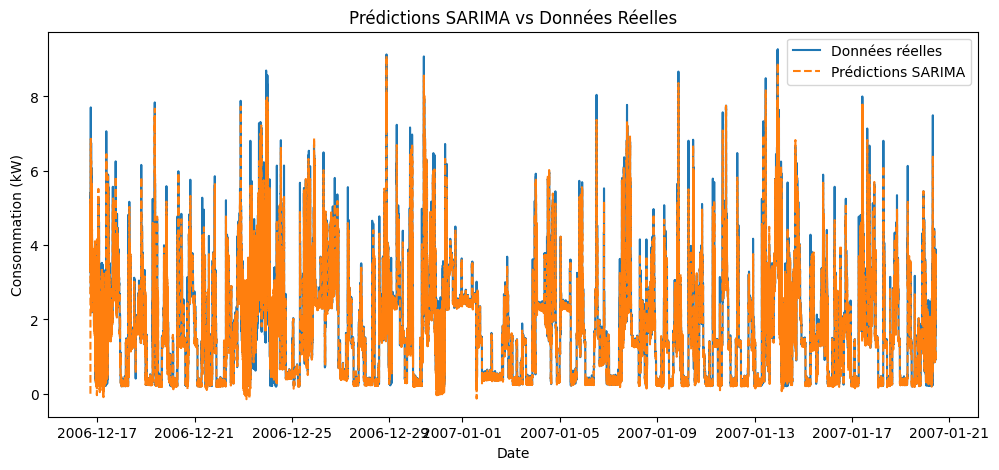

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# D√©finition du mod√®le SARIMA
model_sarima = SARIMAX(df_sample['Global_active_power'],
                        order=(1,0,1), 
                        seasonal_order=(1,0,1,24))

# Entra√Ænement du mod√®le
model_fit_sarima = model_sarima.fit()

# Afficher le r√©sum√© du mod√®le
model_fit_sarima.summary()



In [ ]:
# Pr√©dictions avec index correct
df_sample['forecast_sarima'] = model_fit_sarima.predict(start=df_sample.index[0], end=df_sample.index[-1])

# üìà Comparaison des pr√©dictions SARIMA vs donn√©es r√©elles
plt.figure(figsize=(12,5))
plt.plot(df_sample['Global_active_power'], label="Donn√©es r√©elles")
plt.plot(df_sample['forecast_sarima'], label="Pr√©dictions SARIMA", linestyle="dashed")
plt.title("Pr√©dictions SARIMA vs Donn√©es R√©elles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()

Fr√©quence d√©tect√©e : <Hour>


/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33271D+00    |proj g|=  1.20684D+00


 This problem is unconstrained.



At iterate    5    f=  8.98142D-01    |proj g|=  6.53065D-02

At iterate   10    f=  8.82313D-01    |proj g|=  3.07821D-02

At iterate   15    f=  8.52237D-01    |proj g|=  7.70112D-02

At iterate   20    f=  8.48676D-01    |proj g|=  3.60152D-03

At iterate   25    f=  8.47511D-01    |proj g|=  1.07519D-02

At iterate   30    f=  8.47248D-01    |proj g|=  1.15362D-03

At iterate   35    f=  8.47242D-01    |proj g|=  1.02936D-04

At iterate   40    f=  8.47237D-01    |proj g|=  1.84655D-03

At iterate   45    f=  8.47196D-01    |proj g|=  1.36849D-03


/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.47190D-01    |proj g|=  4.96045D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   4.960D-05   8.472D-01
  F =  0.84719020089021924     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                  Global_active_power   No. Observations:                34589
Model:             SARIMAX(5, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -29303.462
Date:                              Sat, 22 Feb 2025   AIC                         

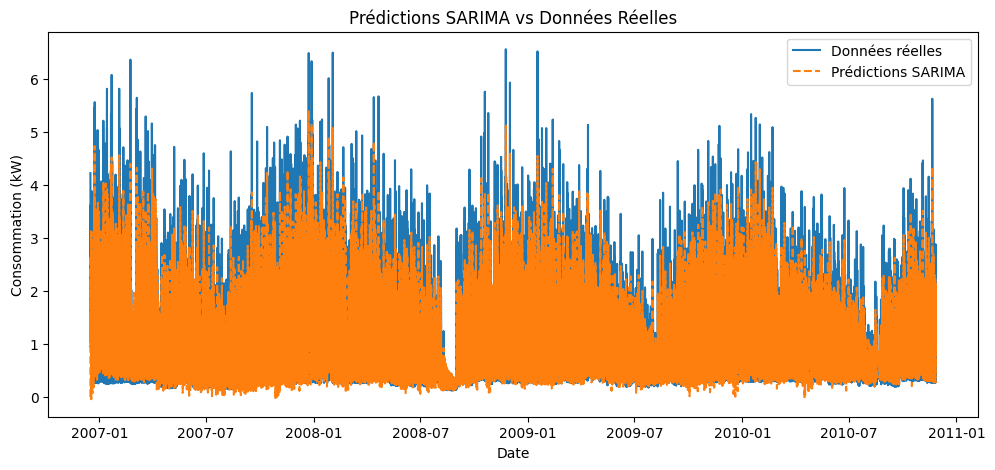

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# V√©rifier et convertir datetime en index
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

# V√©rifier et d√©finir une fr√©quence correcte
if df.index.freq is None:
    df = df.resample('h').mean().interpolate()

print("Fr√©quence d√©tect√©e :", df.index.freq)

# R√©duire la taille des donn√©es
df_sample = df.iloc[:50_000].copy()  # Ajout de .copy() pour √©viter SettingWithCopyWarning

# D√©finir et entra√Æner le mod√®le SARIMA
model = SARIMAX(df_sample['Global_active_power'], order=(5, 0, 2), seasonal_order=(1, 0, 1, 24))
model_fit = model.fit()

# Afficher le r√©sum√© du mod√®le
print(model_fit.summary())

# Pr√©dictions avec index correct
df_sample.loc[:, 'forecast'] = model_fit.predict(start=df_sample.index[0], end=df_sample.index[-1])

# üìà Visualisation des Pr√©dictions
plt.figure(figsize=(12,5))
plt.plot(df_sample['Global_active_power'], label="Donn√©es r√©elles")
plt.plot(df_sample['forecast'], label="Pr√©dictions SARIMA", linestyle="dashed")
plt.title("Pr√©dictions SARIMA vs Donn√©es R√©elles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()


üìä Entra√Ænement du mod√®le SARIMA...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75073D-01    |proj g|=  4.55148D-01

At iterate    5    f=  8.64776D-01    |proj g|=  1.83981D-01

At iterate   10    f=  8.46473D-01    |proj g|=  4.56285D-03

At iterate   15    f=  8.46428D-01    |proj g|=  5.73965D-05

At iterate   20    f=  8.46427D-01    |proj g|=  7.21382D-04

At iterate   25    f=  8.46417D-01    |proj g|=  2.11705D-03

At iterate   30    f=  8.46402D-01    |proj g|=  3.45065D-03

At iterate   35    f=  8.46396D-01    |proj g|=  2.73871D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


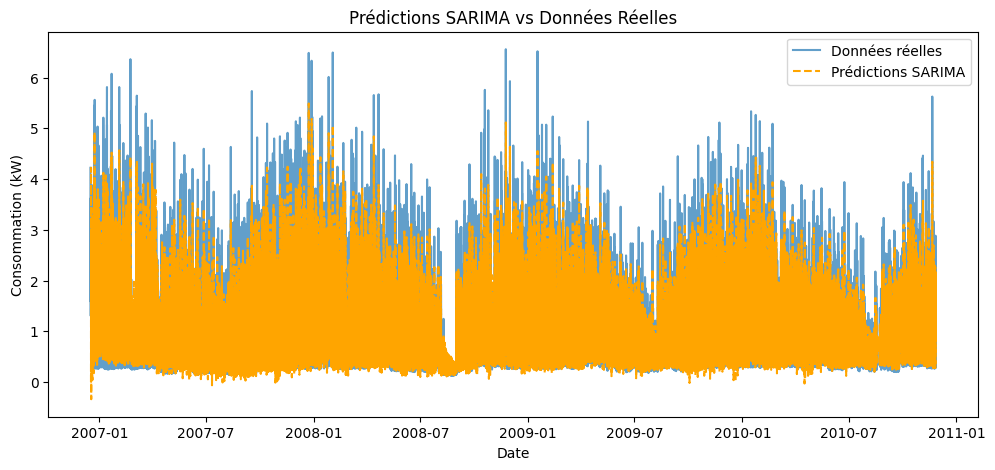


üìä Entra√Ænement du mod√®le ARIMA...


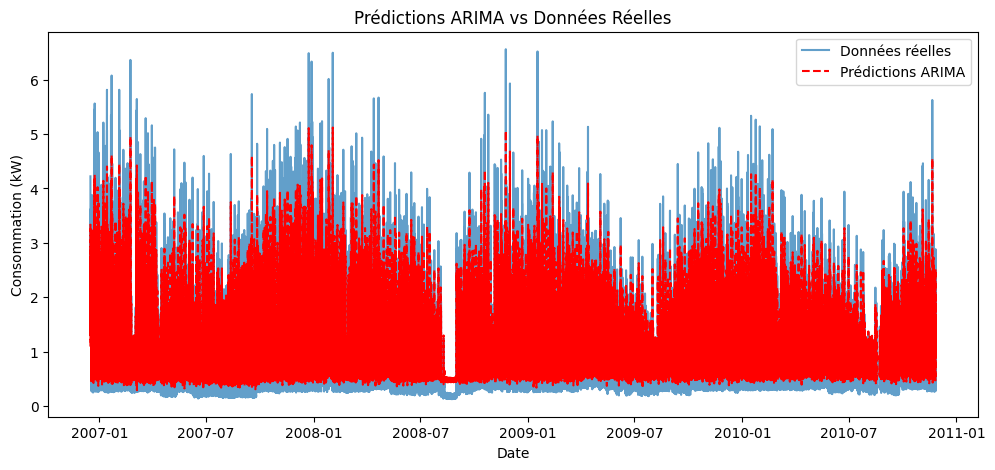

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# üìå V√©rification de datetime en index
df_sample = df_sample.copy()  # √âviter les erreurs de modification

if 'datetime' in df_sample.columns:
    df_sample['datetime'] = pd.to_datetime(df_sample['datetime'])
    df_sample.set_index('datetime', inplace=True)

# üìå V√©rification fr√©quence des donn√©es
if df_sample.index.freq is None:
    df_sample = df_sample.asfreq('h')  # R√©√©chantillonnage horaire

# ‚úÖ üìå Pr√©diction avec SARIMA
print("üìä Entra√Ænement du mod√®le SARIMA...")
model_sarima = SARIMAX(df_sample['Global_active_power'], order=(5, 0, 2), seasonal_order=(1, 1, 1, 24))
model_fit_sarima = model_sarima.fit()
df_sample['forecast_sarima'] = model_fit_sarima.predict(start=df_sample.index[0], end=df_sample.index[-1])

# üìà Visualisation des Pr√©dictions SARIMA
plt.figure(figsize=(12,5))
plt.plot(df_sample['Global_active_power'], label="Donn√©es r√©elles", alpha=0.7)
plt.plot(df_sample['forecast_sarima'], label="Pr√©dictions SARIMA", linestyle="dashed", color='orange')
plt.title("Pr√©dictions SARIMA vs Donn√©es R√©elles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()


# ‚úÖ üìå Pr√©diction avec ARIMA
print("\nüìä Entra√Ænement du mod√®le ARIMA...")
model_arima = ARIMA(df_sample['Global_active_power'], order=(3, 0, 1))
model_fit_arima = model_arima.fit()
df_sample['forecast_arima'] = model_fit_arima.predict(start=df_sample.index[0], end=df_sample.index[-1])

# üìà Visualisation des Pr√©dictions ARIMA
plt.figure(figsize=(12,5))
plt.plot(df_sample['Global_active_power'], label="Donn√©es r√©elles", alpha=0.7)
plt.plot(df_sample['forecast_arima'], label="Pr√©dictions ARIMA", linestyle="dashed", color='red')
plt.title("Pr√©dictions ARIMA vs Donn√©es R√©elles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Charger les donn√©es
df = read_file(file_path)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# V√©rifier et corriger la fr√©quence
if df.index.freq is None:
    df = df.resample('h').mean().interpolate()

# Normalisation des donn√©es pour LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['Global_active_power']])

# D√©finir la fonction pour cr√©er des s√©quences temporelles
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i: i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# D√©finition des param√®tres
time_steps = 24  # Utiliser les 24 derni√®res heures pour pr√©dire la suivante

# S√©paration en train/test (80% train, 20% test)
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Cr√©ation des s√©quences temporelles
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

# Reshape pour √™tre compatible avec LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Shape de X_train :", X_train.shape)
print("Shape de X_test :", X_test.shape)


   Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3            datetime  
0             0.0             1.0            17.0 2006-12-16 17:24:00  
1             0.0             1.0            16.0 2006-12-16 17:25:00  
2             0.0             2.0            17.0 2006-12-16 17:26:00  
3             0.0             1.0            17.0 2006-12-16 17:27:00  
4             0.0             1.0            17.0 2006-12-16 17:28:00  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns)

In [ ]:
# D√©finition du mod√®le LSTM
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compilation du mod√®le
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entra√Ænement du mod√®le
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


864/864 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 9ms/step - loss: 0.0170 - val_loss: 0.0066
Epoch 2/20
864/864 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 7ms/step - loss: 0.0100 - val_loss: 0.0064
Epoch 3/20
864/864 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 7ms/step - loss: 0.0096 - val_loss: 0.0064
Epoch 4/20
864/864 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 7ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 5/20
864/864 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 7ms/step - loss: 0.0091 - val_loss: 0.0063
Epoch 6/20
864/864 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 7ms/step - loss: 0.0092 - val_loss: 0.0062
Epoch 7/20
864/864 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 7ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 8/20
864/864 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 7ms/step - loss: 0.0089 - val_loss: 0.0061
Ep

In [ ]:
# Pr√©dictions avec LSTM
y_pred_lstm = model.predict(X_test)

# D√©normaliser les pr√©dictions
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Ajouter au DataFrame pour comparer
df_results = pd.DataFrame({
    'Date': df.index[-len(y_test):],
    'R√©el': y_test.flatten(),
    'Pr√©diction LSTM': y_pred_lstm.flatten(),
    'Pr√©diction ARIMA': df_sample['forecast'].iloc[-len(y_test):].values,
    'Pr√©diction SARIMA': df_sample['forecast_sarima'].iloc[-len(y_test):].values
}).set_index('Date')

print(df_results.head())


216/216 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step
                          R√©el  Pr√©diction LSTM  Pr√©diction ARIMA  \
Date                                                                
2010-02-12 16:00:00   9.591926         1.641613          1.320388   
2010-02-12 17:00:00   5.101800         1.893013          1.347380   
2010-02-12 18:00:00   4.707455         1.228478          0.806478   
2010-02-12 19:00:00   7.571927         1.261032          0.802965   
2010-02-12 20:00:00  13.760440         1.585716          1.166895   

                     Pr√©diction SARIMA  
Date                                    
2010-02-12 16:00:00           1.292351  
2010-02-12 17:00:00           1.626310  
2010-02-12 18:00:00           1.641237  
2010-02-12 19:00:00           1.760024  
2010-02-12 20:00:00           1.622554  


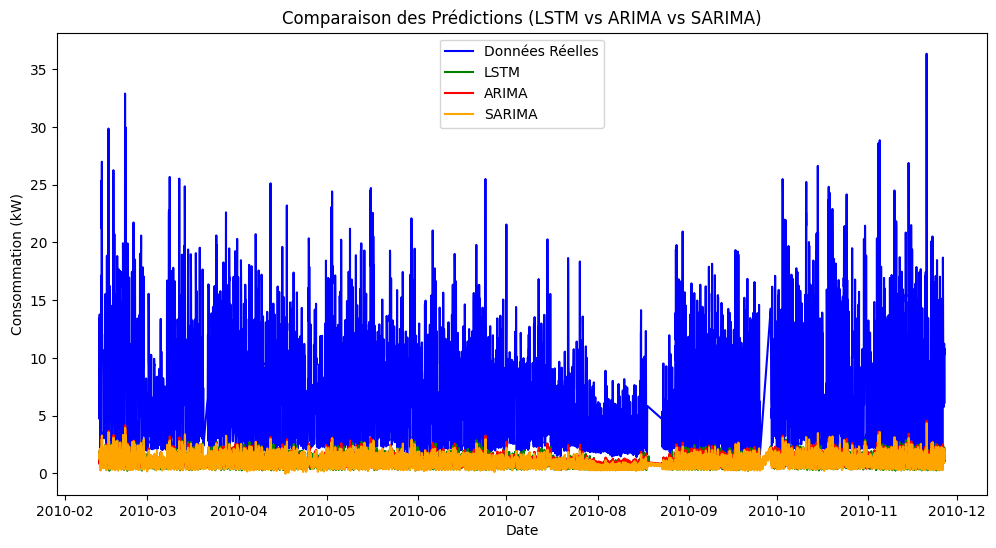

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_results, x='Date', y='R√©el', label='Donn√©es R√©elles', color='blue')
sns.lineplot(data=df_results, x='Date', y='Pr√©diction LSTM', label='LSTM', color='green')
sns.lineplot(data=df_results, x='Date', y='Pr√©diction ARIMA', label='ARIMA', color='red')
sns.lineplot(data=df_results, x='Date', y='Pr√©diction SARIMA', label='SARIMA', color='orange')
plt.title("Comparaison des Pr√©dictions (LSTM vs ARIMA vs SARIMA)")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
rmse_arima = np.sqrt(mean_squared_error(y_test, df_sample['forecast'].iloc[-len(y_test):].values))
rmse_sarima = np.sqrt(mean_squared_error(y_test, df_sample['forecast_sarima'].iloc[-len(y_test):].values))

print(f" RMSE LSTM : {rmse_lstm:.4f}")
print(f" RMSE ARIMA : {rmse_arima:.4f}")
print(f" RMSE SARIMA : {rmse_sarima:.4f}")


 RMSE LSTM : 6.9525
 RMSE ARIMA : 7.0404
 RMSE SARIMA : 7.0170


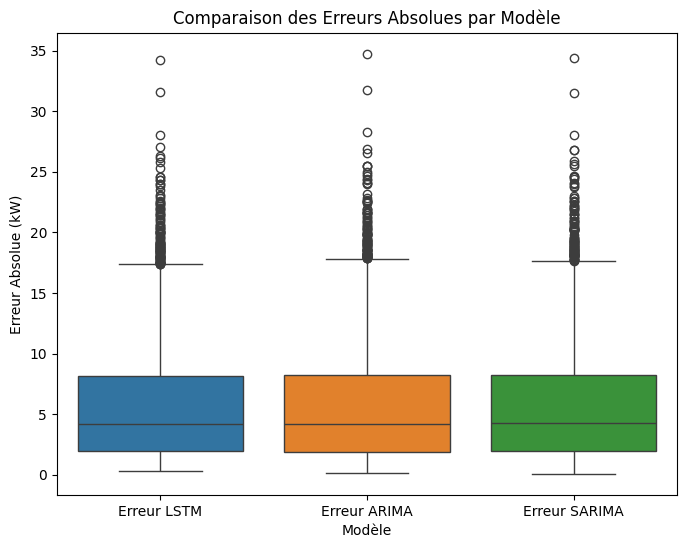

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des erreurs absolues
df_results["Erreur LSTM"] = abs(df_results["R√©el"] - df_results["Pr√©diction LSTM"])
df_results["Erreur ARIMA"] = abs(df_results["R√©el"] - df_results["Pr√©diction ARIMA"])
df_results["Erreur SARIMA"] = abs(df_results["R√©el"] - df_results["Pr√©diction SARIMA"])

# Visualisation en boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_results[["Erreur LSTM", "Erreur ARIMA", "Erreur SARIMA"]])
plt.title("Comparaison des Erreurs Absolues par Mod√®le")
plt.ylabel("Erreur Absolue (kW)")
plt.xlabel("Mod√®le")
plt.show()


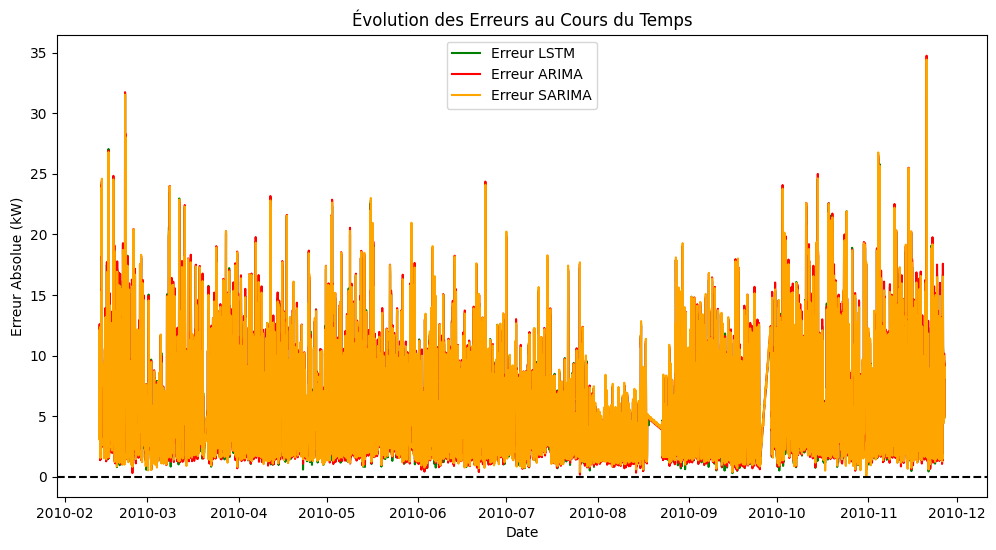

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_results, x='Date', y="Erreur LSTM", label="Erreur LSTM", color="green")
sns.lineplot(data=df_results, x='Date', y="Erreur ARIMA", label="Erreur ARIMA", color="red")
sns.lineplot(data=df_results, x='Date', y="Erreur SARIMA", label="Erreur SARIMA", color="orange")
plt.axhline(0, linestyle="dashed", color="black")  # Ligne √† z√©ro pour r√©f√©rence
plt.title("√âvolution des Erreurs au Cours du Temps")
plt.ylabel("Erreur Absolue (kW)")
plt.xlabel("Date")
plt.legend()
plt.show()


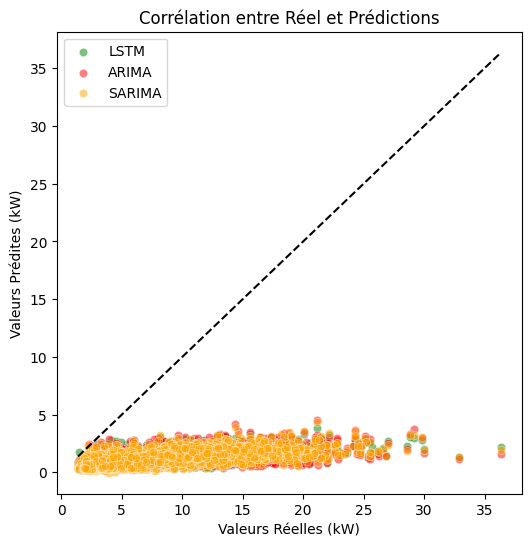

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df_results["R√©el"], y=df_results["Pr√©diction LSTM"], label="LSTM", color="green", alpha=0.5)
sns.scatterplot(x=df_results["R√©el"], y=df_results["Pr√©diction ARIMA"], label="ARIMA", color="red", alpha=0.5)
sns.scatterplot(x=df_results["R√©el"], y=df_results["Pr√©diction SARIMA"], label="SARIMA", color="orange", alpha=0.5)
plt.plot([df_results["R√©el"].min(), df_results["R√©el"].max()], 
         [df_results["R√©el"].min(), df_results["R√©el"].max()], color="black", linestyle="dashed")  # Diagonale id√©ale
plt.xlabel("Valeurs R√©elles (kW)")
plt.ylabel("Valeurs Pr√©dites (kW)")
plt.title("Corr√©lation entre R√©el et Pr√©dictions")
plt.legend()
plt.show()


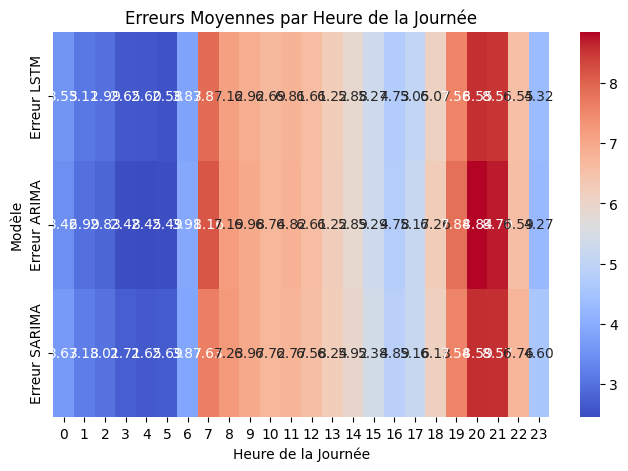

In [ ]:
df_results["Heure"] = df_results.index.hour  # Extraire l'heure de la journ√©e
df_errors = df_results.groupby("Heure")[["Erreur LSTM", "Erreur ARIMA", "Erreur SARIMA"]].mean()

plt.figure(figsize=(8, 5))
sns.heatmap(df_errors.T, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Erreurs Moyennes par Heure de la Journ√©e")
plt.xlabel("Heure de la Journ√©e")
plt.ylabel("Mod√®le")
plt.show()


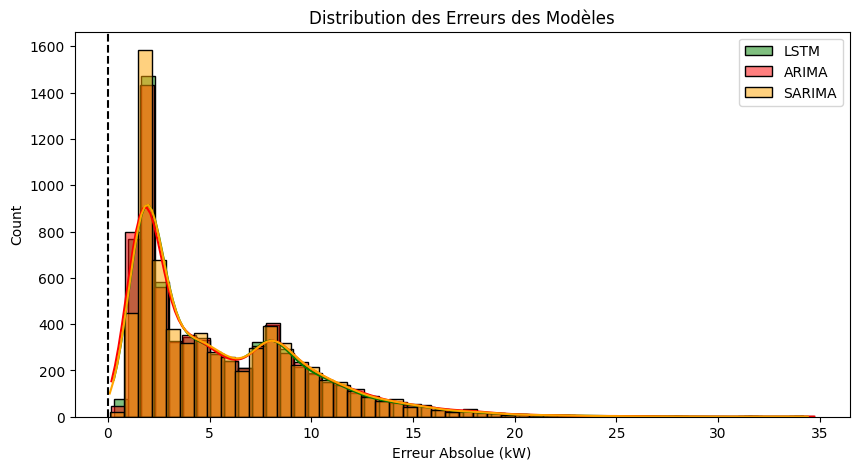

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_results["Erreur LSTM"], bins=50, label="LSTM", color="green", kde=True)
sns.histplot(df_results["Erreur ARIMA"], bins=50, label="ARIMA", color="red", kde=True)
sns.histplot(df_results["Erreur SARIMA"], bins=50, label="SARIMA", color="orange", kde=True)
plt.axvline(0, linestyle="dashed", color="black")  # Ligne z√©ro pour r√©f√©rence
plt.xlabel("Erreur Absolue (kW)")
plt.title("Distribution des Erreurs des Mod√®les")
plt.legend()
plt.show()
